<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter2/EEG%20Signals.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.datasets import fetch_openml

This code downloads an EEG (electroencephalogram) dataset from the OpenML online repository using scikit-learn's [`fetch_openml`] function. The `data_id=1471` argument specifies the exact dataset to fetch (in this case, an EEG dataset), and `as_frame=True` ensures the data is returned as a pandas DataFrame, which is convenient for data analysis and manipulation in Python.

The comment provides the OpenML URL for reference and notes that the EEG measurement covers a total duration of 117 seconds. This setup allows you to easily load and work with real EEG data for further analysis, visualization, or machine learning tasks.

In [2]:
from sklearn.datasets import fetch_openml

eeg = fetch_openml(data_id=1471, as_frame=True)
# https://www.openml.org/d/1471
# the whole measurement spans 117 seconds

This code calculates two important values for working with the EEG dataset:

- `increment` determines the time interval (in seconds) between each data sample. It is computed by dividing the total duration of the EEG recording (117 seconds) by the number of data points in `eeg['data']`. This tells you how much time passes between each consecutive measurement in the dataset.

- `fs` estimates the sampling frequency (samples per second) by dividing the total number of data points by the total duration (117 seconds) using integer division (). This gives you the number of samples collected per second, which is a key parameter for signal processing tasks such as filtering or spectral analysis.

Together, these calculations help you understand the temporal resolution of the EEG data and prepare it for further time series analysis.

In [3]:
increment = 117 / len(eeg['data'])
fs = len(eeg['data']) // 117

In [4]:
len(eeg['data'])

14980

This code creates a time-based index for the EEG signal data and constructs a pandas Series for one of the EEG channels.

First, `np.linspace` generates an array called `index` of evenly spaced values starting at 0 and ending at `increment * len(eeg['data'])`, with the number of points equal to the number of EEG data samples. This array represents the time (in seconds) at which each EEG measurement was taken, assuming a constant sampling interval (`increment`).

Next, `pd.to_datetime(index, unit='s')` converts these time values into pandas datetime objects, treating each value as seconds since the Unix epoch (January 1, 1970). This produces a `DatetimeIndex` suitable for time series analysis.

Finally, a pandas Series named `v1` is created using the values from the 'V1' column of the EEG data. The `ts_index` is used as the index for this Series, aligning each voltage measurement with its corresponding timestamp. This setup allows for easy time-based slicing, plotting, and analysis of the EEG signal.

In [6]:
import numpy as np
index = np.linspace(
    start=0,
    stop=increment*len(eeg['data']),
    num=len(eeg['data'])
)

ts_index = pd.to_datetime(index, unit='s')
v1 = pd.Series(name='V1', data=eeg['data']['V1'].values, index=ts_index)

In [7]:
slicing = (v1.index >= '1970-01-01 00:00:08') & (v1.index <='1970-01-01 00:01:10.000000000')
v1[slicing]

1970-01-01 00:00:08.006208692    4289.74
1970-01-01 00:00:08.014019627    4284.10
1970-01-01 00:00:08.021830563    4280.00
1970-01-01 00:00:08.029641498    4289.74
1970-01-01 00:00:08.037452433    4298.46
                                  ...   
1970-01-01 00:01:09.962547567    4289.74
1970-01-01 00:01:09.970358502    4283.08
1970-01-01 00:01:09.978169437    4284.62
1970-01-01 00:01:09.985980373    4289.23
1970-01-01 00:01:09.993791308    4290.77
Name: V1, Length: 7937, dtype: float64

This code selects a specific time window from the EEG signal data stored in the `v1` pandas Series. The variable `slicing` is a boolean mask that is `True` for all timestamps in the index of `v1` that fall between `'1970-01-01 00:00:08'` and `'1970-01-01 00:01:10.000000000'`, inclusive. 

By applying this mask (`v1[slicing]`), you extract only the EEG measurements recorded within this time interval. This approach is useful for focusing analysis or visualization on a particular segment of the signal, such as examining patterns or events that occur within a specific time range.

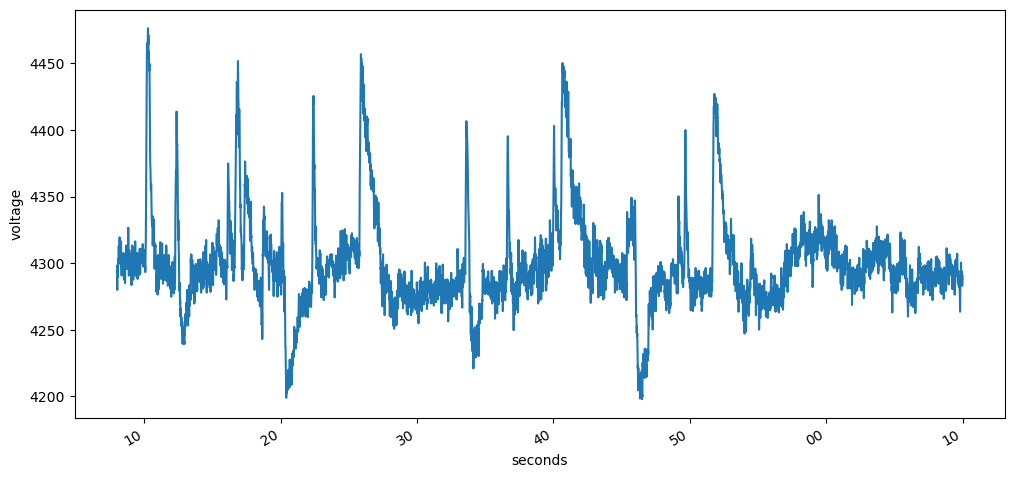

In [8]:
date_formatter = DateFormatter("%S")
ax = v1[slicing].plot(figsize=(12, 6))
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel('voltage')
plt.xlabel('seconds');

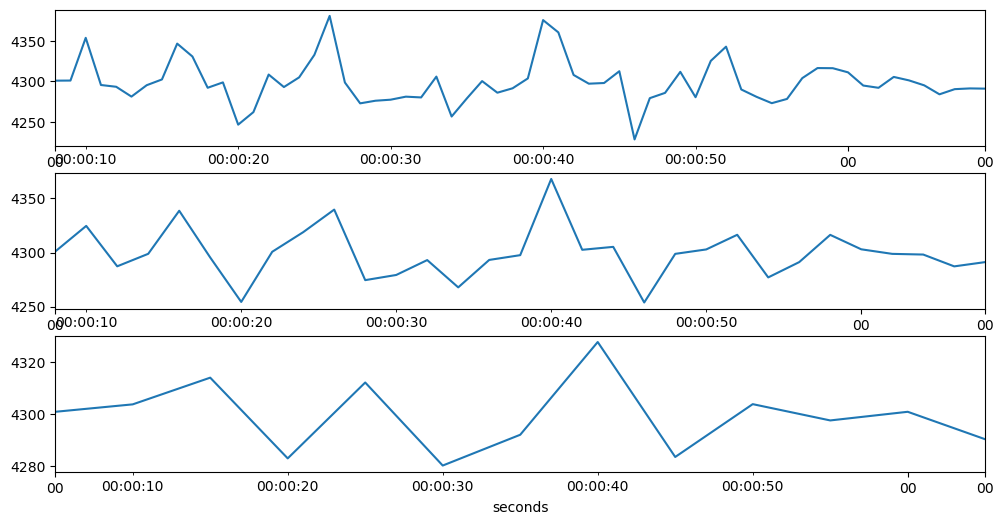

In [9]:
plt.subplot(311)
ax1 = v1[slicing].resample('1s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(312)
ax1 = v1[slicing].resample('2s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(313)
ax2 = v1[slicing].resample('5s').mean().plot(figsize=(12, 6))
ax2.xaxis.set_major_formatter(date_formatter)
plt.xlabel('seconds');

This code creates a figure with three vertically stacked subplots, each showing the EEG signal averaged over different time intervals. 

- `plt.subplot(311)` sets up the first subplot (top panel). The code then takes the selected EEG data (`v1[slicing]`), resamples it into 1-second bins using `.resample('1s').mean()`, and plots the result. The x-axis is formatted to display seconds using `date_formatter`.

- `plt.subplot(312)` sets up the second subplot (middle panel). Here, the EEG data is resampled into 2-second bins, averaged, and plotted in the same way.

- `plt.subplot(313)` sets up the third subplot (bottom panel), resampling the data into 5-second bins before plotting.

The final line, `plt.xlabel('seconds')`, labels the x-axis of the bottom subplot. This visualization allows you to compare how the EEG signal appears at different temporal resolutions, making it easier to spot trends or patterns that may be more or less visible depending on the level of smoothing. A subtle point is that each subplot uses the same data but with different resampling intervals, which can help in understanding the effect of averaging on signal clarity and noise.

In [10]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=4000,
    scaling='spectrum'
)

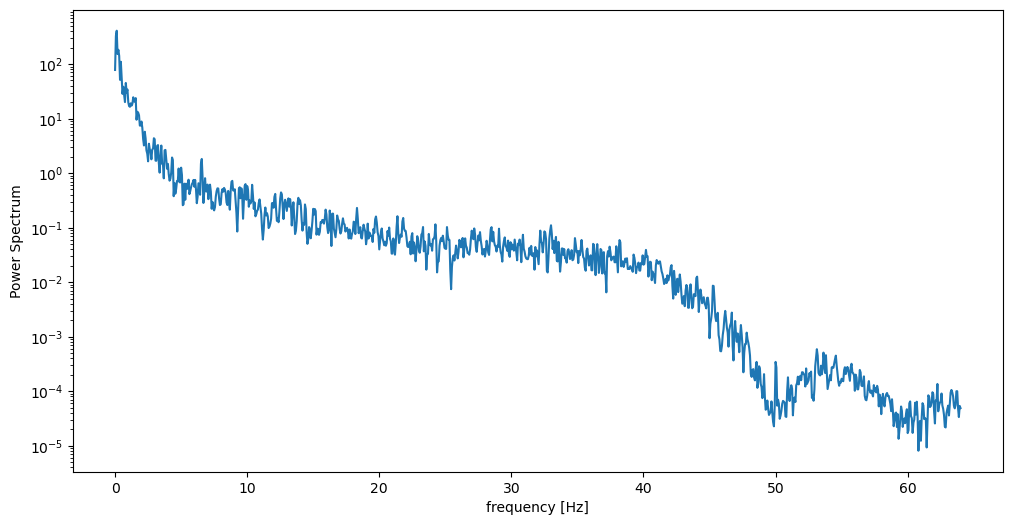

In [11]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=2048,
    scaling='spectrum'
)
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum');

In [17]:
# https://datahub.io/core/global-temp

import pandas as pd
temperatures = pd.read_csv('C:\\Users\\HP\\documents\\dev\\Machine-Learning-for-Time-Series-with-Python\\chapter2\\monthly_csv.csv')
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures = temperatures.pivot_table(index='Date', columns='Source', values='Mean')


In [18]:
temperatures['GCAG'].index.month

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype='int32', name='Date', length=1644)

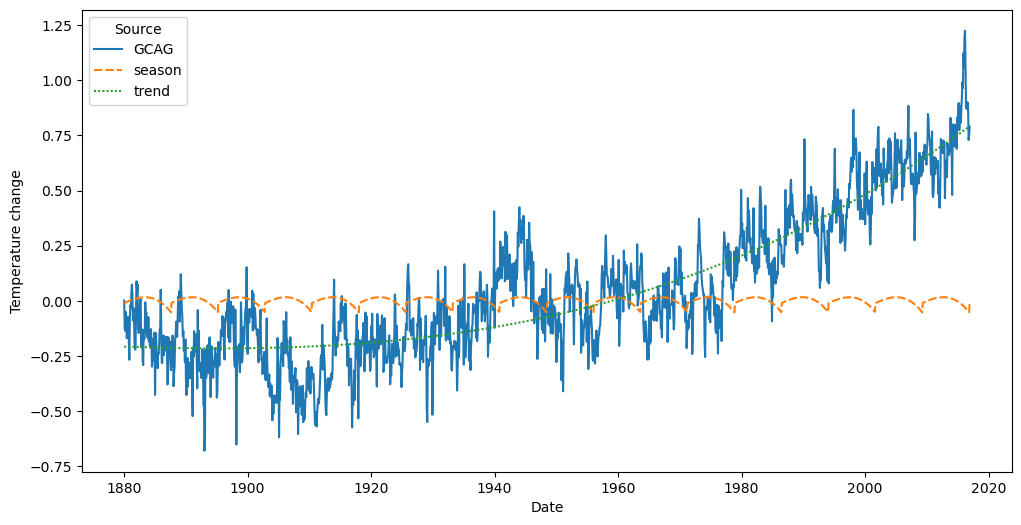

In [19]:
from numpy import polyfit

# fit polynomial: E = \sum_{j=0}^k |p(x_j) - y_j|^2

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)


import seaborn as sns

plt.figure(figsize=(12, 6))
temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - temperatures['trend'])
sns.lineplot(data=temperatures[['GCAG', 'season', 'trend']])
plt.ylabel('Temperature change');

In [21]:
temperatures.head(10)

Source,GCAG,GISTEMP,trend,season
Date,,,,
1880-01-06,0.0009,-0.30,-0.207448,-0.010461
1880-02-06,-0.1229,-0.21,-0.207531,-0.009336
1880-03-06,-0.1357,-0.18,-0.207613,-0.008226
1880-04-06,-0.0499,-0.27,-0.207695,-0.007131
1880-05-06,-0.0738,-0.14,-0.207777,-0.006051
1880-06-06,-0.1692,-0.29,-0.207858,-0.004988
1880-07-06,-0.1491,-0.24,-0.207939,-0.003943
1880-08-06,-0.0725,-0.08,-0.208019,-0.002915
1880-09-06,-0.0817,-0.17,-0.208099,-0.001906
